In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 20})

In [2]:
# Load Aruco detector
parameters = cv2.aruco.DetectorParameters_create()
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_5X5_50)

cameraMatrixR = np.load('cameraMatrixR.npy')
cameraMatrixL = np.load('cameraMatrixL.npy', )
rot = np.load('rot.npy')
trans = np.load('trans.npy')
distL = np.load('distL.npy')
distR = np.load('distR.npy')

trans_calib = np.load('trans_calib.npy')
Rot_calib = np.load('Rot_calib.npy')

In [3]:
def triangulation(p_1,p_2,inv_k_1,inv_k_2,Rot,trans):
    p1 = inv_k_1@p_1
    p2 = inv_k_2@p_2
    lamb = np.linalg.pinv(np.concatenate((p1,-Rot@p2),1))@trans
    return lamb[0,0]*p1

# Processing - without filter:

In [6]:
time_centers = np.load("time_centers_final.npy")
centers_right = np.load("centers_right_final.npy")
centers_left = np.load("centers_left_final.npy")
time_without = []
pos_target = []

alpha = 2.875
beta1 = 385
beta2 = -241.25

for i in range(0,len(time_centers)):    
    if not np.array([0,0]) in centers_right[i] and not np.array([0,0]) in centers_left[i]:
        xyz_1 = triangulation(np.array([[centers_right[i][0][0]],[centers_right[i][0][1]],[1]]),np.array([[centers_left[i][0][0]],[centers_left[i][0][1]],[1]]),np.linalg.inv(cameraMatrixR),np.linalg.inv(cameraMatrixL),rot,trans)    
        xyz_3 = triangulation(np.array([[centers_right[i][1][0]],[centers_right[i][1][1]],[1]]),np.array([[centers_left[i][1][0]],[centers_left[i][1][1]],[1]]),np.linalg.inv(cameraMatrixR),np.linalg.inv(cameraMatrixL),rot,trans)    
        xyz_4 = triangulation(np.array([[centers_right[i][2][0]],[centers_right[i][2][1]],[1]]),np.array([[centers_left[i][2][0]],[centers_left[i][2][1]],[1]]),np.linalg.inv(cameraMatrixR),np.linalg.inv(cameraMatrixL),rot,trans)    

    else:
        xyz_1 = np.array([[0],[0],[0]])
        xyz_2 = np.array([[0],[0],[0]])
        xyz_3 = np.array([[0],[0],[0]])
        print("Not good point!")     
          
   
    #if xyz_1[2]>0 and xyz_3[2]>0 and xyz_4[2]>0:
    if xyz_1[2]>0 and xyz_3[2]>0 and xyz_4[2]>0 and xyz_1[2]>385 and (alpha*xyz_1[0]+xyz_1[2])>beta1 and (alpha*xyz_1[0]-xyz_1[2])<beta2:                
        z_axis = (xyz_3-xyz_1)/np.linalg.norm(xyz_3-xyz_1)
        x_axis = np.cross(z_axis.reshape(3),(xyz_4-xyz_1).reshape(3))
        x_axis = x_axis/np.linalg.norm(x_axis)
        y_axis = np.cross(z_axis.reshape(3),x_axis.reshape(3))
        
        x_axis = x_axis.reshape(3,1)
        y_axis = y_axis.reshape(3,1)
        
        xyz = xyz_1 + 248.5*z_axis - 7.5*y_axis
        
        if xyz[1]>125:        
            pos_target.append(xyz)
            time_without.append(time_centers[i])
#    else:
#        print(xyz_1)
        
        
time_without = np.array(time_without)

Text(0, 0.5, 'Z position (mm)')

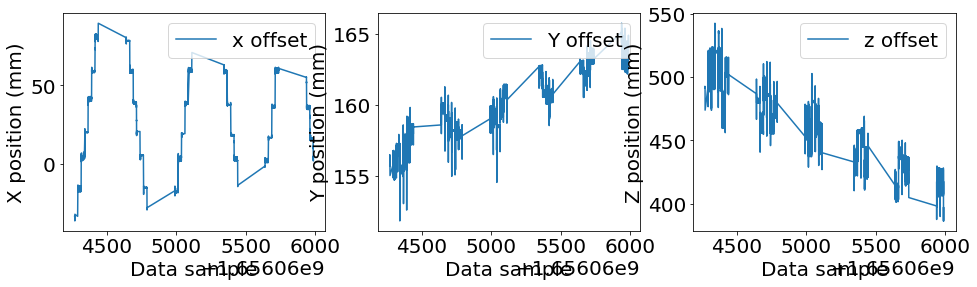

In [7]:
pos_target = np.array(pos_target)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(time_without,pos_target[:,0])
plt.legend(["x offset"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("X position (mm)")

plt.subplot(1, 3, 2)
plt.plot(time_without,pos_target[:,1])
plt.legend(["Y offset"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("Y position (mm)")

plt.subplot(1, 3, 3)
plt.plot(time_without,pos_target[:,2])
plt.legend(["z offset"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("Z position (mm)")

# Filtering

## Gaussian

In [8]:
k = 20
filtsigG = []
time_filtered = []
for i in range(k+1,len(time_without)-k-1):    
    gtime = time_without[i-k:i+k]-time_without[i]
    gauswin = np.exp( -(4*np.log(2)*gtime**2))
    gauswin = gauswin / np.sum(gauswin)
    
    filtsigG.append([np.sum( pos_target[i-k:i+k,0]*gauswin/(2*k) ),
                     np.sum( pos_target[i-k:i+k,1]*gauswin/(2*k) ),
                     np.sum( pos_target[i-k:i+k,2]*gauswin/(2*k) )])
    time_filtered.append(time_without[i])

filtsigG = np.array(filtsigG)
time_filtered = np.array(time_filtered)

## Processing

In [9]:
data_processed = []
time_processed = []

for i in range(0,len(time_filtered)):
    if filtsigG[i][2]>0 and filtsigG[i][2]>0 and filtsigG[i][2]>0 and filtsigG[i][2]>405 and (alpha*filtsigG[i][0]+filtsigG[i][2])>410 and (alpha*filtsigG[i][0]-filtsigG[i][2])<-245.25:                
        if filtsigG[i][1]>156:        
            data_processed.append(filtsigG[i])
            time_processed.append(time_filtered[i])
            
data_processed = np.array(data_processed)
time_processed = np.array(time_processed)

Text(0, 0.5, 'Z position (mm)')

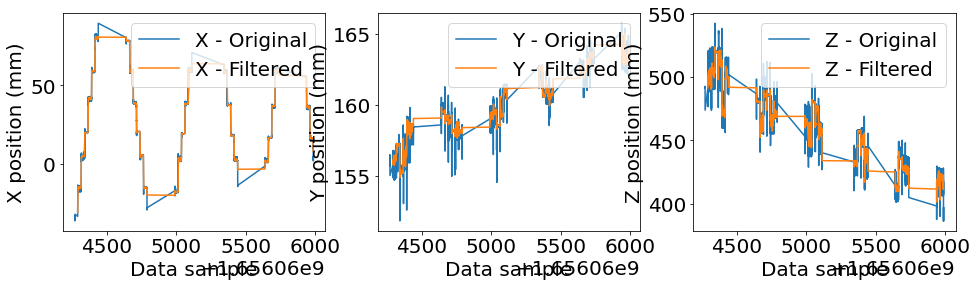

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(time_without,pos_target[:,0])
plt.plot(time_filtered,filtsigG[:,0])
plt.legend(["X - Original","X - Filtered"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("X position (mm)")

plt.subplot(1, 3, 2)
plt.plot(time_without,pos_target[:,1])
plt.plot(time_filtered,filtsigG[:,1])
plt.legend(["Y - Original","Y - Filtered"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("Y position (mm)")

plt.subplot(1, 3, 3)
plt.plot(time_without,pos_target[:,2])
plt.plot(time_filtered,filtsigG[:,2])
plt.legend(["Z - Original","Z - Filtered"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("Z position (mm)")


# Results

In [11]:
data_polaris = pd.read_csv("tip_positions_polaris_2022_06_24.csv")
#data_polaris = pd.read_csv("tip_positions_polaris_full_2022_06_24.csv")

xyz_polaris = trans_calib+Rot_calib@np.array(data_polaris[["Tx","Ty","Tz"]]).T
#xyz_polaris = np.array(data_polaris[["Tx","Ty","Tz"]]).T

time_polaris = np.array(data_polaris["time"])
#time_polaris = np.array(data_polaris["timestamp"])

In [12]:
#### OPTIMAL Volume


time_polaris = time_polaris[np.logical_and(np.logical_and(2.875*xyz_polaris[0,:] + xyz_polaris[2,:] > 405,2.875*xyz_polaris[0,:]-xyz_polaris[2,:] <-235.25),
                          xyz_polaris[2,:]  > 390)]
xyz_polaris = xyz_polaris[:,np.logical_and(np.logical_and(2.875*xyz_polaris[0,:] + xyz_polaris[2,:] > 405,2.875*xyz_polaris[0,:]-xyz_polaris[2,:] <-235.25),
                          xyz_polaris[2,:]  > 390)]

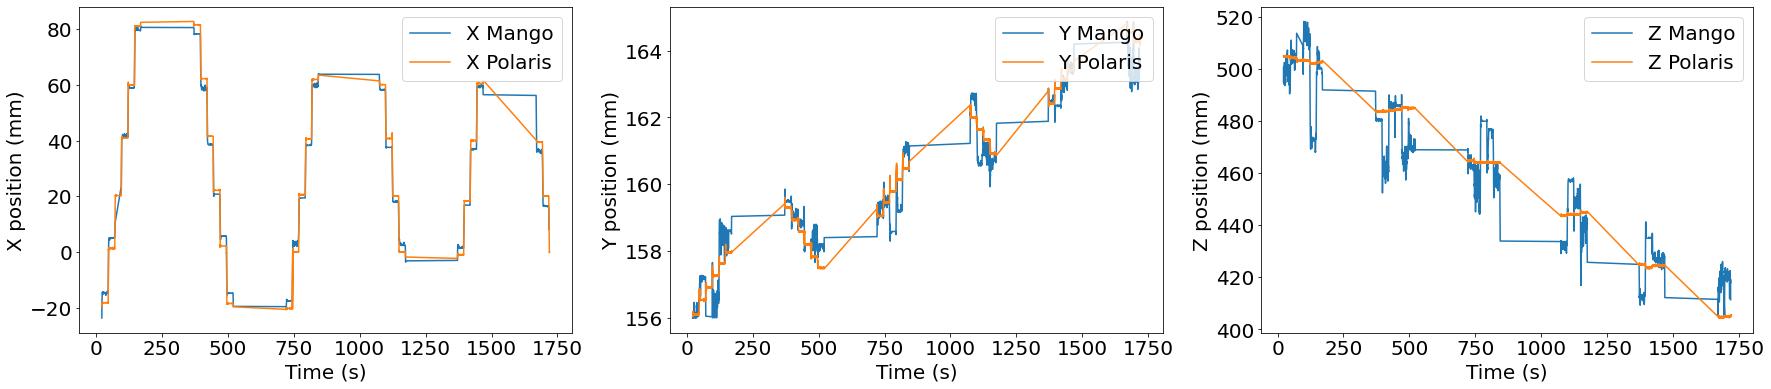

In [13]:
data_ploting = np.array(pos_target)
#data_ploting = filtsigG
data_ploting = data_processed

time_ploting = time_without
#time_ploting = np.array(time_filtered)
time_ploting = time_processed

#%matplotlib notebook
plt.figure(figsize=(30, 6))


plt.subplot(1, 3, 1)
plt.plot(time_ploting-time_without[0],data_ploting[:,0],)
plt.plot(time_polaris-time_without[0],xyz_polaris.T[:,0],)
plt.legend(["X Mango","X Polaris"],loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("X position (mm)")

plt.subplot(1, 3, 2)
plt.plot(time_ploting-time_without[0],data_ploting[:,1])
plt.plot(time_polaris-time_without[0],xyz_polaris.T[:,1])
plt.legend(["Y Mango","Y Polaris"],loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("Y position (mm)")

plt.subplot(1, 3, 3)
plt.plot(time_ploting-time_without[0],data_ploting[:,2])
plt.plot(time_polaris-time_without[0],xyz_polaris.T[:,2])
plt.legend(["Z Mango","Z Polaris"],loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("Z position (mm)")

plt.savefig('tip_pos.png')

In [14]:
temp1 = 0
x_error = []
y_error = []
z_error = []
time_graph = []
pos_err = []
dif_time = []

for i in range(0,len(time_ploting)):
    temp2 = np.argmin(np.abs(time_polaris-time_ploting[i]))
    dif_time.append(np.abs(time_polaris[temp2]-time_ploting[i]))
    #if not temp1 == temp2:
    if not temp1 == temp2 and np.abs(time_polaris[temp2]-time_ploting[i]) < 0.01:

        temp1 = temp2
        error = data_ploting[i].reshape(3,1)-xyz_polaris.T[temp2].reshape(3,1)
        x_error.append(error[0])
        y_error.append(error[1])
        z_error.append(error[2])
        time_graph.append(time_ploting[i])
        pos_err.append(data_ploting[i])

x_error = np.array(x_error)
y_error = np.array(y_error)
z_error = np.array(z_error)
time_graph = np.array(time_graph)
time_graph = time_graph
pos_err = np.array(pos_err)

rmse = [np.sqrt(x_error.T@x_error/len(x_error)),np.sqrt(y_error.T@y_error/len(y_error)),np.sqrt(z_error.T@z_error/len(z_error))]
print(rmse)

mae = [np.abs(x_error).sum()/len(x_error),np.abs(y_error).sum()/len(y_error),np.abs(z_error).sum()/len(z_error)]
print(mae)

[array([[2.67916152]]), array([[0.60934736]]), array([[12.2359443]])]
[2.4843903325973695, 0.47835694883477825, 9.693278642526156]


In [15]:
dif_time = np.array(dif_time)
dif_time.mean()

0.028816623228081203

Text(0, 0.5, 'Z position (mm)')

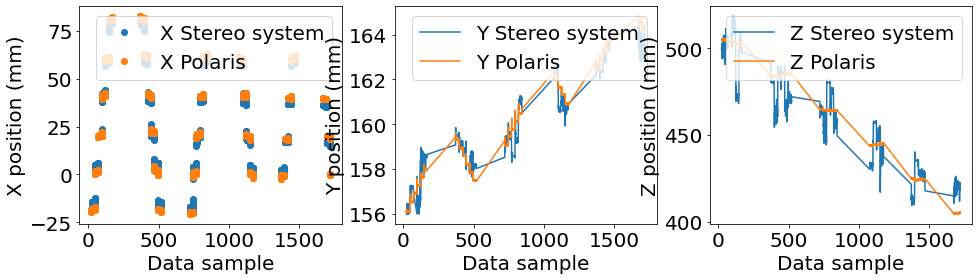

In [16]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(time_graph-time_without[0],pos_err[:,0],'o')
plt.plot(time_polaris-time_without[0],xyz_polaris.T[:,0],'o')
plt.legend(["X Stereo system","X Polaris"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("X position (mm)")

plt.subplot(1, 3, 2)
plt.plot(time_graph-time_without[0],pos_err[:,1])
plt.plot(time_polaris-time_without[0],xyz_polaris.T[:,1])
plt.legend(["Y Stereo system","Y Polaris"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("Y position (mm)")

plt.subplot(1, 3, 3)
plt.plot(time_graph-time_without[0],pos_err[:,2])
plt.plot(time_polaris-time_without[0],xyz_polaris.T[:,2])
plt.legend(["Z Stereo system","Z Polaris"],loc="upper right")
plt.xlabel("Data sample")
plt.ylabel("Z position (mm)")